In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv(f)
    data[f.replace(".csv", "")] = d

Reading in data.

In [9]:
all_survey = pd.read_csv("survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

Reading in Survey data.

In [10]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

Add DBN Columns.

In [11]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

Convert columns to numeric.

In [12]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

Condensing Datasets.

In [13]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

Converting AP Scores to Numeric.

In [14]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

Combining the datasets.

In [15]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

Adding a school district column.

In [16]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

Finding correlations.

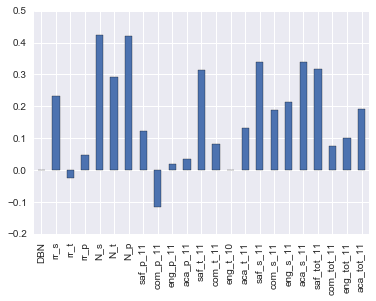

In [17]:
combined.corr()["sat_score"][survey_fields].plot.bar()

From the bar plot above, we can see that there are high positive correlations between sat_score and N_s, N_t, N_p. Since these columns are correlated to Total_enrollment, it makes sense for them to have high correlation.

Also, rr_s has a strong correlation with sat_score indicating that the rate of students responding to the survey is high as is the sat_score, since they are more likely to fill out the response.

How students and teachers perceived safety is also highly correlated with sat_score since more secure the environment is, better the performace.

The last interesting observation is that, how students perceived academic standards i.e aca_s_11 is strongly correlated to sat_score but is not so for parents i.e aca_p_11 and teachers aca_t_11.

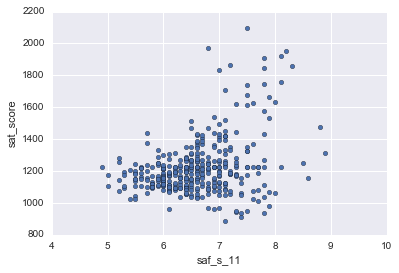

In [18]:
combined.plot.scatter(x='saf_s_11', y='sat_score')
plt.show()

The general trend seems to be true i.e higher the safety, better are the SAT scores. Although there is no strong correlation between them.

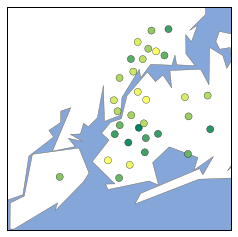

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

The above viz shows the safety score grouped by school district. And we can observe that parts of upper Manhattan, Queens and Bronx have low safety score. Whereas, Brooklyn has high safety scores.

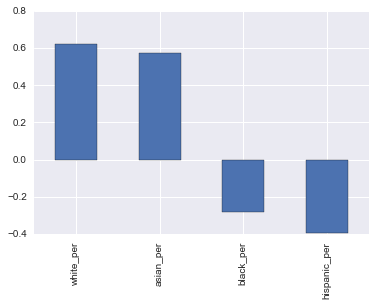

In [20]:
race_fields = ['white_per','asian_per','black_per','hispanic_per']
combined.corr()['sat_score'][race_fields].plot.bar()

From the bar plot above, you can see that there is a strong positive correlation between white and asian students in accordance to the sat_scores whereas there is a strong negative correlation when it comes to hispanic students. This could be due to a lack of funding for schools which have a higher black/hispanic student population.

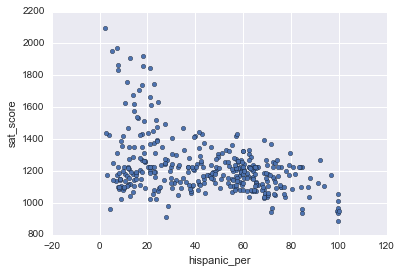

In [21]:
combined.plot.scatter(x='hispanic_per',y='sat_score')
plt.show()

The scatter plot above between percentange of hispanic students and sat_score seems to be consistent and hows a strong linear negative correlation indicating the higher the percentange of hispanic students, lower is the sat_score for that school.

In [22]:
hisp_less_than_95 = combined[combined['hispanic_per'] > 95]
print(hisp_less_than_95['School Name'])

44             MANHATTAN BRIDGES HIGH SCHOOL
82                                         0
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIE
125                                        0
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object


On a quick Google search about the schools above, we can figure out that the schools have a high majority of International students i.e immigrants to U.S and hence are learning English which in turn indicates low SAT scores.

In [23]:
hisp_less_than_10 = combined[combined['hispanic_per'] < 10]
sat_greater_than_1800 = hisp_less_than_10[hisp_less_than_10['sat_score'] > 1800]
print(sat_greater_than_1800['School Name'])

37                    STUYVESANT HIGH SCHOOL
151             BRONX HIGH SCHOOL OF SCIENCE
187           BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES A
356      STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: School Name, dtype: object


The schools mentioned above have a low Hispanic student percentage and a high average SAT score. The reason for this is that these schools have specialized science and technology programs which get additional funding and also require students to take an entrace test to gain admission. This indicates a high SAT score.
Although this does not indicate any information regarding the low Hispanic student percentage since the schools have a mixture of students of all ethnicities and from all over New York.

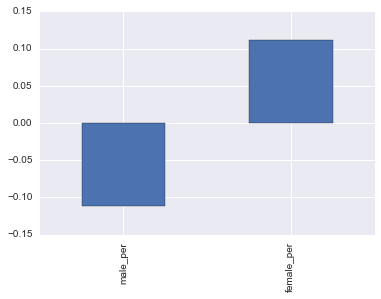

In [26]:
combined.corr()['sat_score'][['male_per','female_per']].plot.bar()

From the above correlation between male_per, female_per and sat_score we can see that a high percentage of females have a strong positive correlation whereas a high percentage of males has a strong negative correlation.

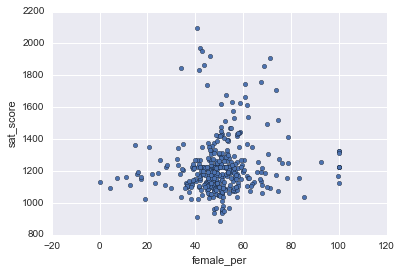

In [28]:
combined.plot.scatter(x='female_per', y='sat_score')
plt.show()

From the scatter plot between female_per and sat_score we can see that there doesnt seem to be a linear relationship between them, however there is a cluster with high percentage of females and high SAT scores.

In [29]:
filtered_df = combined[combined['female_per'] > 60]
filtered_df = filtered_df[filtered_df['sat_score'] > 1700]
print(filtered_df['School Name'])

5            BARD HIGH SCHOOL EARLY COLLEGE
26            ELEANOR ROOSEVELT HIGH SCHOOL
60                       BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF
302             TOWNSEND HARRIS HIGH SCHOOL
Name: School Name, dtype: object


The schools mentioned above are Liberal Arts school and have a selective program which tends to point to the high SAT score.

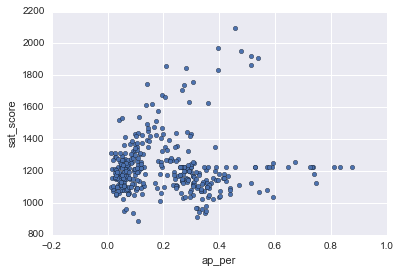

In [30]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined.plot.scatter(x='ap_per',y='sat_score')
plt.show()

There doesn't seem to be a strong correlation between ap_per and sat_score but there is a cluster where high ap_per tends to point towards a high sat_score.

In [31]:
filtered_df = combined[combined['ap_per'] > 0.4]
filtered_df = filtered_df[filtered_df['sat_score'] > 1800]
print(filtered_df['School Name'])

37                    STUYVESANT HIGH SCHOOL
155    HIGH SCHOOL OF AMERICAN STUDIES AT LE
302              TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES A
356      STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: School Name, dtype: object


Again, the schools mentioned above are technical and science related and have a very selective program pointing towards a high sat_score.